# クラス化したデータ読み込み用のクラスとCameraクラスの使い方を確認する

これまで見てきたデータの取り出し方をdataset.pyに、座標系の変換はcamera.pyにまとめた。
ここでは、クラスの使い方を例を見ながら確認する。

また、深層学習のフレームワークはPyTorchを使う予定であるため、扱うテンソルは `np.ndarray` から `torch.tensor`に変更する。

まずはdataset.pyから見ていく

In [1]:
import sys
sys.path.append("../../src/")

In [2]:
from dataset import VKITTI2

In [3]:
dataset = VKITTI2(root_dir="../../data")  # pytorch dataset class

loading sequences


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


In [4]:
sample_idx = 10
sample = dataset[10]

In [5]:
sample.keys()

dict_keys(['rgb_-1', 'depth_-1', 'extrinsic_-1', 'intrinsic_-1', 'rgb_0', 'depth_0', 'extrinsic_0', 'intrinsic_0'])

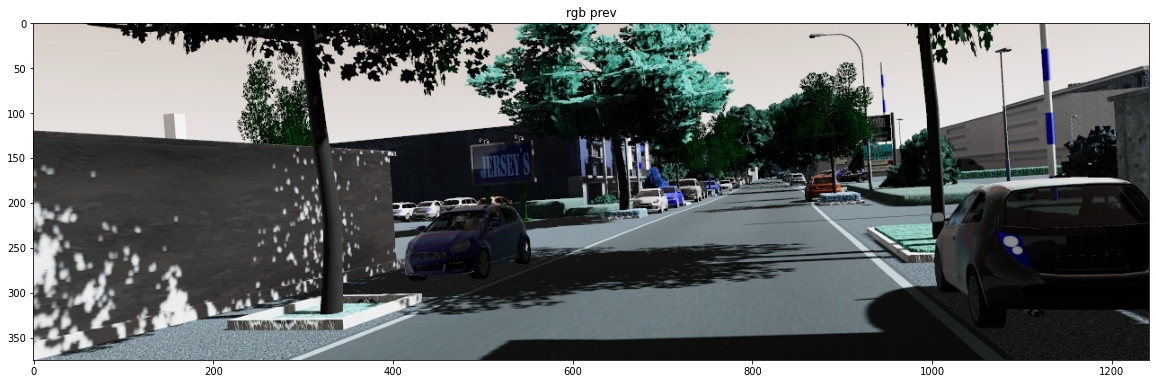

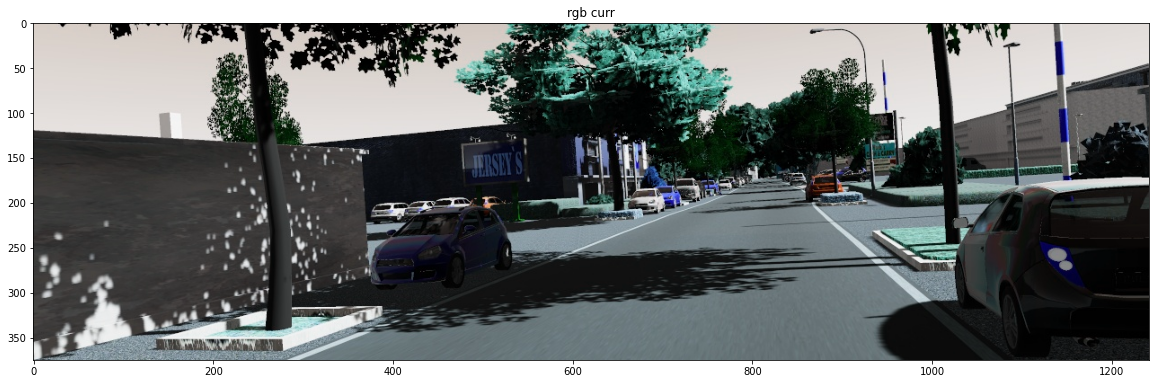

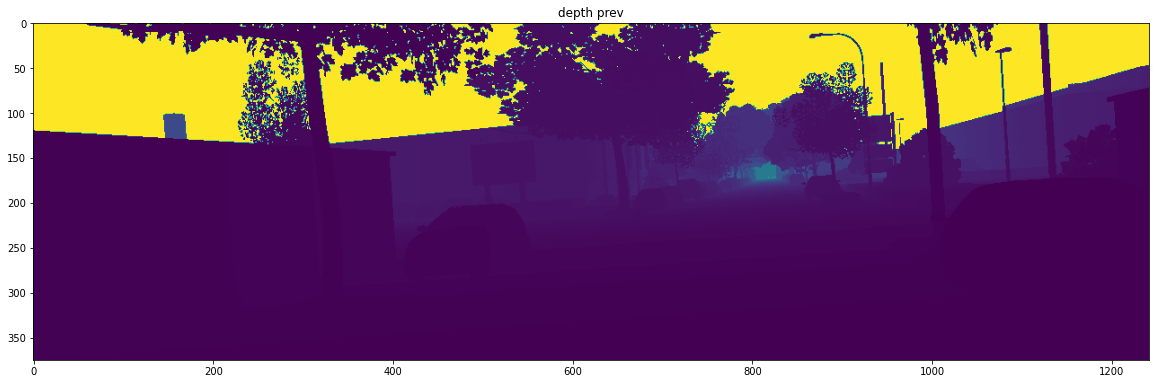

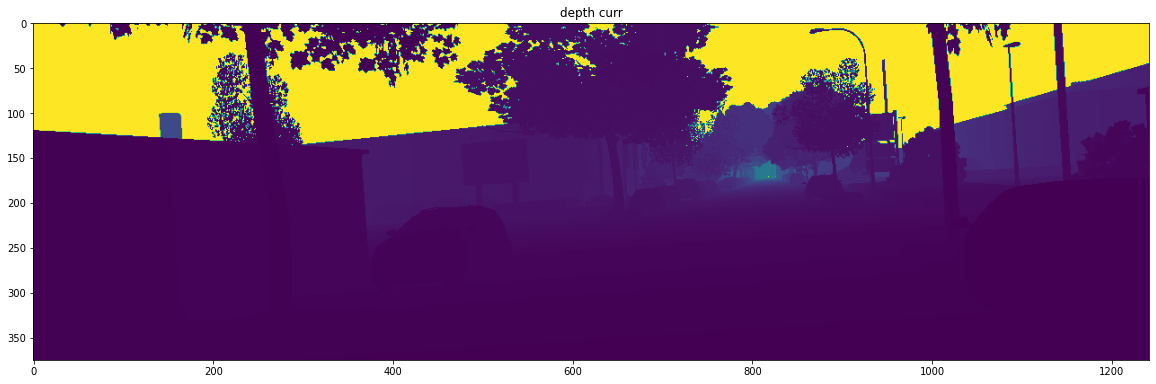

In [19]:
import matplotlib.pyplot as plt
import torch
import numpy as np



rgb_curr = torch.tensor(sample["rgb_0"])
rgb_prev = torch.tensor(sample["rgb_-1"])
depth_curr = torch.tensor(sample["depth_0"].astype(np.int32))
depth_prev = torch.tensor(sample["depth_-1"].astype(np.int32))

plt.figure(figsize=(20, 20))
plt.title("rgb prev")
plt.imshow(rgb_prev)
plt.show()

plt.figure(figsize=(20, 20))
plt.title("rgb curr")
plt.imshow(rgb_curr)
plt.show()

plt.figure(figsize=(20, 20))
plt.title("depth prev")
plt.imshow(depth_prev)
plt.show()

plt.figure(figsize=(20, 20))
plt.title("depth curr")
plt.imshow(depth_curr)
plt.show()

In [7]:
extrinsic_curr, intrinsic_curr = torch.tensor(sample["extrinsic_0"], dtype=torch.float32), torch.tensor(sample["intrinsic_0"], dtype=torch.float32)
extrinsic_prev, intrinsic_prev = torch.tensor(sample["extrinsic_-1"], dtype=torch.float32), torch.tensor(sample["intrinsic_-1"], dtype=torch.float32)

# 外部パラメタの変化量を確認
extrinsic_curr - extrinsic_prev

tensor([[-8.4043e-05,  2.9591e-04,  2.0504e-05, -2.6998e-01],
        [-7.7818e-04, -2.6226e-05,  3.0150e-04,  3.6301e-02],
        [-6.1989e-06,  7.8397e-04, -2.8968e-05, -9.4001e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

次にcamera.pyを見ていく

In [8]:
from camera import PinholeCamera
import torch

In [9]:
# 以前と同様にmeshgridで画像座標を生成する
xi = torch.arange(0, depth_curr.shape[1], 1)
yi = torch.arange(0, depth_curr.shape[0], 1)
coord_x, coord_y = torch.meshgrid(xi, yi, indexing="xy")

image_coords_curr = torch.stack([coord_x, coord_y], axis=-1)
image_coords_curr = image_coords_curr.float()

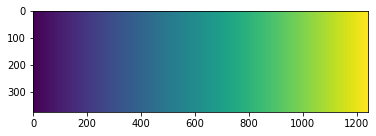

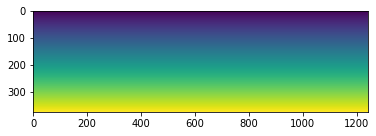

In [10]:
plt.imshow(image_coords_curr[..., 0])
plt.show()
plt.imshow(image_coords_curr[..., 1])
plt.show()

In [11]:
world_coords_curr = PinholeCamera.image2world(image_coords_curr, intrinsic_curr, extrinsic_curr, depth_curr)

In [12]:
world_coords_curr.long()

tensor([[[ 672, -313,  539,    1],
         [ 672, -313,  538,    1],
         [ 672, -313,  537,    1],
         ...,
         [ 665, -237, -577,    1],
         [ 665, -237, -577,    1],
         [ 665, -237, -578,    1]],

        [[ 672, -312,  539,    1],
         [ 672, -312,  538,    1],
         [ 672, -312,  537,    1],
         ...,
         [ 665, -237, -576,    1],
         [ 665, -237, -577,    1],
         [ 665, -236, -578,    1]],

        [[ 672, -311,  539,    1],
         [ 672, -311,  538,    1],
         [ 672, -311,  538,    1],
         ...,
         [ 665, -236, -576,    1],
         [ 665, -236, -577,    1],
         [ 665, -236, -578,    1]],

        ...,

        [[  19, -111,    2,    1],
         [  19, -111,    2,    1],
         [  19, -111,    2,    1],
         ...,
         [  17, -111,   -8,    1],
         [  17, -111,   -8,    1],
         [  17, -111,   -8,    1]],

        [[  19, -111,    2,    1],
         [  19, -111,    2,    1],
         [  

In [13]:
image_coords_prev = PinholeCamera.world2image(world_coords_curr, intrinsic_prev, extrinsic_prev)

In [14]:
# normalize the coord to be in [-1, 1] for grid sampling
image_coords_prev_norm = image_coords_prev.clone()
image_coords_prev_norm[..., 0] = image_coords_prev[..., 0] / image_coords_curr.shape[1] * 2 - 1
image_coords_prev_norm[..., 1] = image_coords_prev[..., 1] / image_coords_curr.shape[0] * 2 - 1

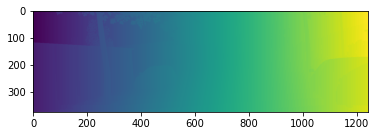

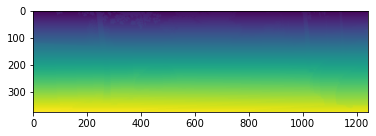

In [15]:
plt.imshow(image_coords_prev[..., 0])
plt.show()
plt.imshow(image_coords_prev[..., 1])
plt.show()

In [16]:
rgb_prev_ = rgb_curr.float().unsqueeze(0).permute(0, 3, 1, 2)
grid = image_coords_prev_norm.unsqueeze(0)
rgb_curr_to_prev = torch.nn.functional.grid_sample(rgb_curr_, grid)

/Users/yudai/Downloads/monocular_depth_estimation_from_scratch/env/lib/python3.7/site-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


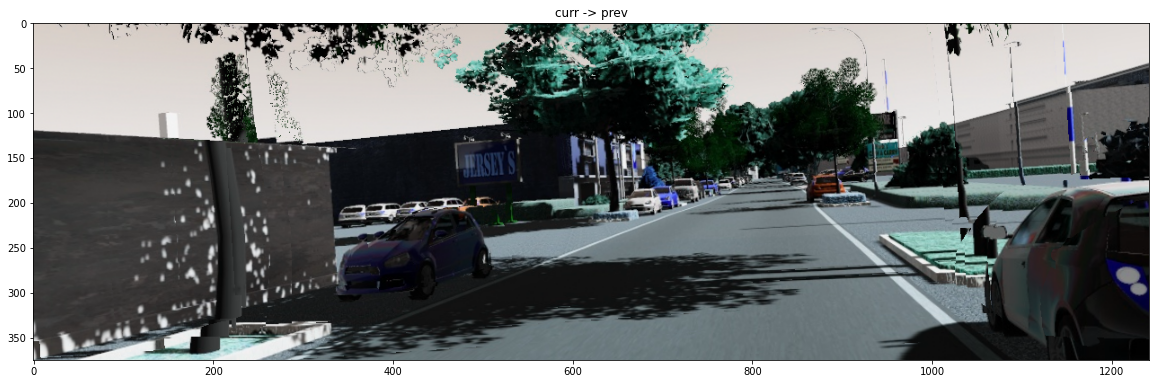

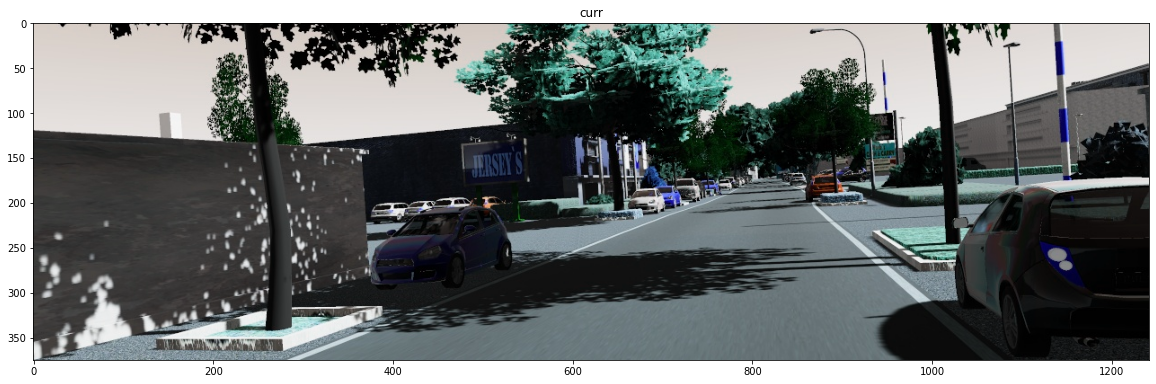

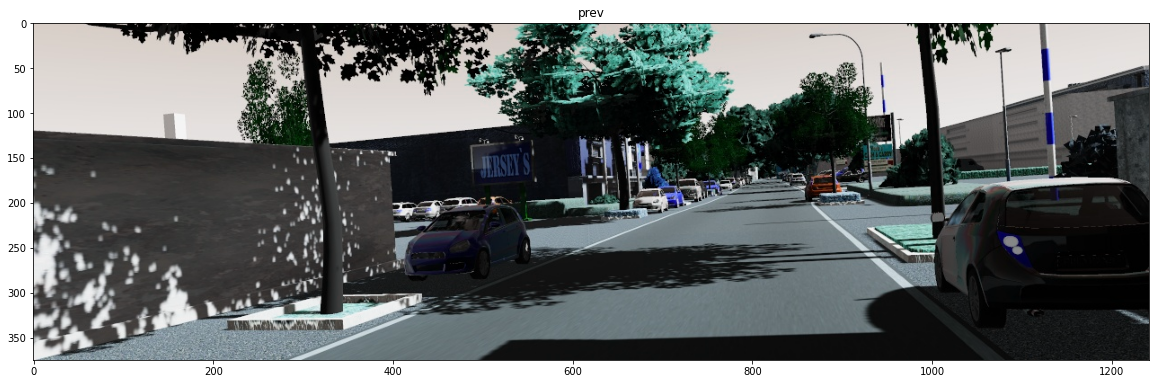

In [17]:
rgb_curr_to_prev_show = rgb_curr_to_prev.long().squeeze(0).permute(1, 2, 0).numpy()

plt.figure(figsize=(20, 20))
plt.title("curr -> prev")
plt.imshow(rgb_curr_to_prev_show)
plt.show()

plt.figure(figsize=(20, 20))
plt.title("curr")
plt.imshow(rgb_curr)
plt.show()

plt.figure(figsize=(20, 20))
plt.title("prev")
plt.imshow(rgb_prev)
plt.show()

